#Extracting embeddings of words with BERT

## Introduzione
L'obiettivo dello studio proposto è quello di utilizzare il modello BERT per creare degli embeddings i tweets di SENTIPOLC.

Se si esegue il notebook per la prima volta, si consiglia di seguire la struttura proposta, pensata appositamente per mostrare tutti gli step da eseguire per una corretta implementazione di Bert; alternativamente, è possibile procedere come di seguito:
 

1.   esecuzione delle prime celle per istanziare le librerie 
2.   importazione del dataset preprocessato
3.   tokenizzazione
4.   Estrazione embeddings mediante le procedure complete proposte, dipendemente dalla metodologia che si vuole adottare per ottenere l' *embedding*





# Installazione delle librerie

In [ ]:
!pip install pytorch-pretrained-bert

     |████████████████████████████████| 133kB 8.1MB/s 
     |████████████████████████████████| 133kB 9.0MB/s 
     |████████████████████████████████| 7.0MB 12.3MB/s 
     |████████████████████████████████| 71kB 11.0MB/s 
ERROR: botocore 1.19.33 has requirement urllib3<1.27,>=1.25.4; python_version != "3.4", but you'll have urllib3 1.24.3 which is incompatible.


In [ ]:
!pip install tensorflow-gpu==1.15

     |████████████████████████████████| 411.5MB 38kB/s 
     |████████████████████████████████| 512kB 51.7MB/s 
     |████████████████████████████████| 3.8MB 53.8MB/s 
     |████████████████████████████████| 51kB 8.7MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=f7d5eb13c253413ea9c1b5a7527c9bcbe9f67790c6464ed696dca7c004561591
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.3.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorflow-estimator<2.4.0,>=2.3.0, but you'll have tensorflow-estimator 1.15.1 which is incompatible.
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing i

# Preprocessing Dataset
## Importazione del dataset e analisi

Definizione di un metodo che permetta di reperire i files dal nostro Google Drive senza necessità di utilizzare il mount, ma specificando unicamente l'id del file  di interesse. [Qui](https://buomsoo-kim.github.io/colab/2018/04/16/Importing-files-from-Google-Drive-in-Google-Colab.md/) la  guida utilizzata per ottenere gli id di interesse.

In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

def get_from_drive (file_id,file_name):
  # Authenticate and create the PyDrive client.
  # This only needs to be done once per notebook.
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  # Download a file based on its file ID.
  #
  # A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
  downloaded = drive.CreateFile({'id': file_id})
  downloaded.GetContentFile(file_name)



In [5]:
import pandas
dataset_DF = pandas.read_csv("db_creagritrend.csv")
print(dataset_DF)
print("colonne:   ")
dataset_DF

       id  ... label_bin_ALB
0       1  ...             0
1       2  ...             0
2       3  ...            10
3       4  ...             0
4       5  ...             0
..    ...  ...           ...
995   996  ...             0
996   997  ...             0
997   998  ...             1
998   999  ...             0
999  1000  ...             0

[1000 rows x 10 columns]
colonne:   


,id,text,text_clean,Giudizio,label_pos,label_neg,label_AlBERTo_pos,label_AlBERTo_neg,label_bin_ANN,label_bin_ALB
0,1,"@confagricoltura #Riso, procedura per ripristi...",procedura ripristino dazi rush finale regolame...,Negativo,1,0,0,0,10,0
1,2,"@GArancioni Gelate, xylella, sblocco Psr. A #B...",gelate xylella sblocco psr invasione video por...,Molto negativo,0,1,0,0,1,0
2,3,@SocialConfeuro @GArancioni #GiletArancioni. P...,confeuro protesta giusta serve coerenza assunz...,Positivo,1,1,1,0,11,10
3,4,@_Unaitalia Uova. Timbratura all’origine neces...,uova timbratura origine necessaria tutelare co...,Negativo,1,0,0,0,10,0
4,5,@EUauditors @giamma71 / Sicurezza alimentare ...,sicurezza alimentare sostanze chimiche sistema...,Negativo,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
995,996,"My week on Twitter 🎉: 174 Mentions, 3.3M Menti...",my week on twitter mentions m mention reach li...,Neutro,0,0,0,0,0,0
996,997,#Tradizione torna protagonista a #tavola con a...,torna protagonista arrivo stime italiani spend...,Molto positivo,1,0,0,0,10,0
997,998,"Clima, Coldiretti: il Natale bollente con temp...",clima coldiretti natale bollente temperature a...,Negativo,0,1,0,1,1,1
998,999,"USA-UE, @masgiansanti: “Possibili nuovi #dazi ...",usa ue possibili nuovi d oliva,Positivo,0,1,0,0,1,0


In [ ]:
dataset_DF

,id,text,text_clean,score_value,n_token,n_token_sent,Giudizio,Vpos,Vneg,Mpos,Mneg,Gpos,Gneg,Apos,Aneg
0,1,"@confagricoltura #Riso, procedura per ripristi...",procedura ripristino dazi rush finale regolame...,"-0,42978740",9,3,Negativo,0,0,1,0,1,0,1,0
1,2,"@GArancioni Gelate, xylella, sblocco Psr. A #B...",gelate xylella sblocco psr invasione video por...,"-2,20651320",10,2,Molto negativo,0,0,0,1,0,1,0,1
2,3,@SocialConfeuro @GArancioni #GiletArancioni. P...,confeuro protesta giusta serve coerenza assunz...,"0,49758673",7,5,Positivo,0,0,1,1,0,1,1,0
3,4,@_Unaitalia Uova. Timbratura all’origine neces...,uova timbratura origine necessaria tutelare co...,"-2,10462380",9,3,Negativo,0,0,1,0,1,1,1,0
4,5,@EUauditors @giamma71 / Sicurezza alimentare ...,sicurezza alimentare sostanze chimiche sistema...,"-1,69732377",17,12,Negativo,0,0,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,"My week on Twitter 🎉: 174 Mentions, 3.3M Menti...",my week on twitter mentions m mention reach li...,"0,00000000",16,0,Neutro,0,0,0,0,0,0,1,0
996,997,#Tradizione torna protagonista a #tavola con a...,torna protagonista arrivo stime italiani spend...,"4,46359565",16,12,Molto positivo,1,0,1,0,1,0,1,0
997,998,"Clima, Coldiretti: il Natale bollente con temp...",clima coldiretti natale bollente temperature a...,"-1,88858211",13,9,Negativo,0,1,0,1,0,1,0,1
998,999,"USA-UE, @masgiansanti: “Possibili nuovi #dazi ...",usa ue possibili nuovi d oliva,"2,38699930",6,3,Positivo,0,1,0,1,0,1,1,0


In [6]:
#PREPARE TRAINING SENTENCES
!pip install ekphrasis

from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
import pandas as pd
import numpy as np

text_processor = TextPreProcessor (
    # terms that will be normalized
    normalize=[ 'url' , 'email', 'user', 'percent', 'money', 'phone', 'time', 'date', 'number'] ,
    # terms that will be annotated
    annotate={"hashtag"} ,
    fix_html=True ,  # fix HTML tokens

    unpack_hashtags=True ,  # perform word segmentation on hashtags

    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    dicts = [ emoticons ]
)

     |████████████████████████████████| 81kB 9.7MB/s 
     |████████████████████████████████| 184kB 29.1MB/s 
     |████████████████████████████████| 71kB 12.1MB/s 
  Created wheel for ekphrasis: filename=ekphrasis-0.5.1-cp36-none-any.whl size=82844 sha256=79f6881efee83f04aafd720168470312aaa7d84d22282b67b2b043cc59f965c7
  Stored in directory: /root/.cache/pip/wheels/2f/c5/9b/c9b60f535a2cf9fdbc92d84c4801a010c35a9cd348011ed2a1
  Created wheel for ftfy: filename=ftfy-5.8-cp36-none-any.whl size=45613 sha256=db893d59a7ef7ff9ae38f3623983bd30a70dfc7b0cb8deba80f3b0a7c6cdc4ea
  Stored in directory: /root/.cache/pip/wheels/ba/c0/ef/f28c4da5ac84a4e06ac256ca9182fc34fa57fefffdbc68425b
Successfully built ekphrasis ftfy
Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading english - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/english/counts_1grams.txt
Reading english - 2grams ...
generating cache file for faster loading...
re

In [7]:
#final examples training
examples = []

import re
for index, item in dataset_DF.iterrows():
    s = item["text"]
    s = s.lower()
    s = str(" ".join(text_processor.pre_process_doc(s)))
    s = re.sub(r"[^a-zA-ZÀ-ú</>!?♥♡\s\U00010000-\U0010ffff]", ' ', s)
    s = re.sub(r"\s+", ' ', s)
    s = re.sub(r'(\w)\1{2,}',r'\1\1', s)
    s = re.sub ( r'^\s' , '' , s )
    s = re.sub ( r'\s$' , '' , s )
    #print(s)
    examples.append(s)

dataset_DF["clean"] = examples

Per l'esperimento sarà necessario conservare la colonna relativa al plot, al titolo del libro, ed (eventualmente) un identificativo univoco.
Dal dataset ridotto, salvato in un nuovo dataframe, ricaviamo alcune utili statistiche per visualizzare eventuali null values.

In [8]:
import numpy as np

dataset_DF.replace("N/A", np.nan, inplace=True)
print("Null values dataset:")
print(dataset_DF.isnull().sum())

Null values dataset:
id                    0
text                  0
text_clean           14
Giudizio              0
label_pos             0
label_neg             0
label_AlBERTo_pos     0
label_AlBERTo_neg     0
label_bin_ANN         0
label_bin_ALB         0
clean                 0
dtype: int64


In [9]:
print("Dimensioni del dataset preprocessato ma con null values: " + str(dataset_DF.shape))
dataset_DF.dropna(inplace=True)
print("Dimensioni del dataset preprocessato e privo di null values: " + str(dataset_DF.shape))
print("Null values dataset:")
print(dataset_DF.isnull().sum())

Dimensioni del dataset preprocessato ma con null values: (1000, 11)
Dimensioni del dataset preprocessato e privo di null values: (986, 11)
Null values dataset:
id                   0
text                 0
text_clean           0
Giudizio             0
label_pos            0
label_neg            0
label_AlBERTo_pos    0
label_AlBERTo_neg    0
label_bin_ANN        0
label_bin_ALB        0
clean                0
dtype: int64


Importazione di google drive per salvare i files successivamente

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Effettuiamo il salvataggio del dataframe preprocessato per operazioni future.

In [11]:
import json
dataset_DF.to_csv('/content/drive/MyDrive/SI_AI_KBS/integrazione_AlBERTo_WMAL/sentipolc_agritrend/data/creagritrend_processed.csv')

print("File salvato nella memoria di Google Drive")

File salvato nella memoria di Google Drive


## **Tokenizzazione**






In [ ]:
import sys

!test -d bert_repo || git clone https://github.com/google-research/bert bert_repo
if not 'bert_repo' in sys.path:
  sys.path += ['bert_repo']

# import python modules defined by BERT
import tokenization

Cloning into 'bert_repo'...
remote: Enumerating objects: 340, done.
remote: Total 340 (delta 0), reused 0 (delta 0), pack-reused 340
Receiving objects: 100% (340/340), 315.49 KiB | 13.14 MiB/s, done.
Resolving deltas: 100% (185/185), done.


Importiamo le librerie necessarie alla inizializzazione del tokenizzatore di BERT; come si può notare dall'ultima riga dello stralcio di codice, sarà adottato il *BERT base uncased*

In [ ]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM
import numpy as np
# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)
  
# Load pre-trained model tokenizer (vocabulary)
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer = tokenization.FullTokenizer("vocab.txt", do_lower_case=True)


Procediamo con la tokenizzazione e con il calcolo della lunghezza media dei dei plot tokenizzati, così da poter appurare quale sarà l'input che andremo a offrire a BERT.
Tutti i plot tokenizzati saranno salvati in una lista chiamata *lista_plot_tokenized*


In [ ]:
import time
dataset_reduced = dataset_DF
start_time = time.time()
lista_text_tokenized = []
lista_lunghezze = []
i = 0 #per tenere conto dell'indice del plot
over_128 = 0 #conteggio dei plots che superano i 512 tokens
for text in dataset_reduced["clean"]:
  i+=1
  marked_text=text
  tokenized_text = tokenizer.tokenize(marked_text)
  tokenized_text.insert(0,"[CLS]")
  tokenized_text.append("[SEP]")
  #print(tokenized_text)
  lista_text_tokenized.append(tokenized_text)
  lunghezza = len(tokenized_text)
  lista_lunghezze.append(lunghezza)
  #stampiamo solo i plots che eccedono nella lunghezza massima, pari a 512
  if lunghezza > 128:
    over_128+=1
  if (i%100)==0:
    print(str(i) + " text tokenizzati")
print("Tokenizzazione effettuata in: " + str(time.time() - start_time) + " secondi.")
print(lista_lunghezze)
media_plot = np.mean(lista_lunghezze)
print("Media lunghezza " + str(media_plot))
print("Deviazione std " + str(np.std(lista_lunghezze)))
print("# Text che superano i 128 caratteri: " + str(over_128))


100 text tokenizzati
200 text tokenizzati
300 text tokenizzati
400 text tokenizzati
500 text tokenizzati
600 text tokenizzati
700 text tokenizzati
800 text tokenizzati
900 text tokenizzati
Tokenizzazione effettuata in: 0.4243435859680176 secondi.
[42, 53, 42, 31, 40, 70, 88, 24, 24, 34, 48, 23, 53, 59, 34, 45, 39, 43, 46, 36, 83, 80, 50, 51, 41, 75, 36, 38, 40, 37, 45, 35, 58, 59, 55, 84, 29, 27, 26, 28, 45, 29, 40, 41, 37, 32, 47, 38, 43, 41, 19, 42, 28, 23, 26, 32, 53, 44, 32, 28, 39, 20, 30, 49, 37, 21, 28, 32, 25, 31, 28, 31, 30, 25, 25, 24, 91, 43, 31, 54, 40, 22, 34, 54, 24, 18, 23, 37, 41, 42, 23, 23, 34, 27, 30, 30, 43, 38, 42, 27, 19, 31, 41, 34, 27, 33, 27, 23, 36, 23, 40, 33, 29, 28, 42, 65, 19, 20, 60, 34, 23, 22, 20, 25, 33, 39, 38, 35, 28, 30, 17, 31, 28, 23, 35, 38, 34, 58, 34, 48, 29, 37, 32, 18, 31, 16, 41, 41, 50, 33, 39, 34, 21, 48, 41, 88, 13, 48, 26, 33, 22, 34, 31, 77, 15, 16, 163, 112, 16, 37, 31, 14, 140, 86, 28, 34, 35, 27, 42, 25, 21, 76, 66, 23, 24, 33, 36, 2

### Riduzione tokens
BERT non accetta sequenze di token superiori ai 128, dunque è necessario tagliare le liste che eccedono in ciò.

In [ ]:
i = 0
for tokenized_plot in lista_text_tokenized:
  if len(tokenized_plot) >= 127:
    tokenized_text_reduced = tokenized_plot[:127]
    tokenized_text_reduced.append("[SEP]")
    lista_text_tokenized[i] = tokenized_text_reduced
  i+=1

Eseguita la tokenizzazione, vanno indicizzati i tokens in base agli elementi presenti nel vocabolario di BERT e attribuiti dei segment ids a ogni token presente in una frase: analogamente al precedente stralcio di codice, salviamo tutte le liste di token indicizzati e segment ids in liste che permettano la **corrispondenza 1:1** tra gli elementi al loro interno e quelli presenti in *list_idexed_tokens*

### Indicizzazione tokens e segment ids

Le liste su cui andremo a ciclare, come accennato in precedenza, hanno una corrispondenza 1:1 tra tokens e indici del vocabolario di Bert 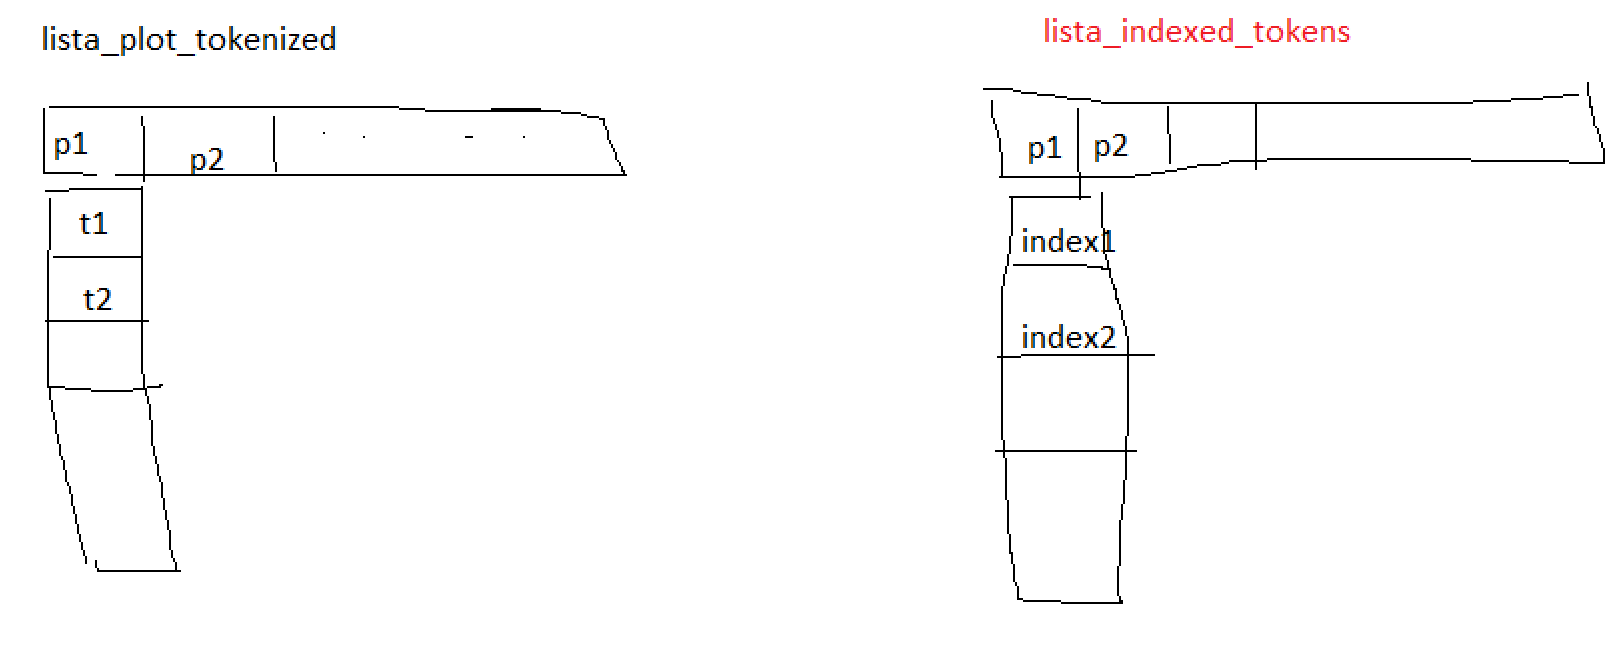

In [ ]:
# Map the token strings to their vocabulary indeces.
list_indexed_tokens = [] #lista che ospiterà tutte le liste di tokens
list_segments_ids = []# lista che ospiterà i segment ids per ogni lista di tokens 
for plot_tokenized in lista_text_tokenized:
  list_indexed_tokens.append(tokenizer.convert_tokens_to_ids(plot_tokenized))
  list_segments_ids.append([1] * len(plot_tokenized))

# Display the words with their indeces.
for tup in zip(lista_text_tokenized[342], list_indexed_tokens[342]):
    print('{:<12} {:>6,}'.format(tup[0], tup[1])) #stampa di un plot di esempio
print("#tokens plot 343(342) = " + str(len(lista_text_tokenized[342])) + " # segment_ids " + str(len(list_segments_ids[342])))

[CLS]             2
mercati       4,455
contadini    22,395
consiglio       830
di               12
stato           184
non              19
obbligatorio  9,706
aderire      15,364
a                14
<                 6
ha               53
##shtag      13,411
>            127,748
cold         18,856
ir            9,185
etti         17,135
<                 6
/               110
ha               53
##shtag      13,411
>            127,748
per              22
poter         1,157
vendere       3,360
la               17
sentenza      2,290
<                 6
ur           14,013
##l             902
>            127,748
[SEP]             3
#tokens plot 343(342) = 32 # segment_ids 32


# Estrazione embeddings


## **Procedura completa**


In [ ]:
!pip install transformers

     |████████████████████████████████| 1.4MB 8.0MB/s 
     |████████████████████████████████| 2.9MB 59.9MB/s 
     |████████████████████████████████| 890kB 39.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=856f78665014f6089c0eabcfd9fde6d5dbb9aa9f7d788fe2097dde3bdda72a04
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
from transformers import BertModel

In [ ]:
embedding_list = []

In [ ]:
import time
start_time = time.time()
lista_dizionari = []
model = BertModel.from_pretrained('m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0', output_hidden_states=True)
model.eval()
i = 0
for indexed_tokens in list_indexed_tokens:
  dizionario_embeddings = {}
  # para:esecuzione di bert
  tokens_tensor = torch.tensor([indexed_tokens])
  segments_ids = list_segments_ids[i]
  segments_tensors = torch.tensor([segments_ids])

  with torch.no_grad():
      out = model(tokens_tensor, segments_tensors)
  encoded_layers = out.hidden_states
  ##################################################################

  # para: combining the layers in one big tensor
  #token_embeddings = torch.stack(encoded_layers, dim=0)
  ##################################################################

  # para: Removal of the batch dimension
  #token_embeddings = torch.squeeze(token_embeddings, dim=1)
  ##################################################################

  #para: swap dimensions layers and tokens
  #token_embeddings = token_embeddings.permute(1,0,2)
  ##################################################################

  #para: caso ultimo layer
  token_vecs = encoded_layers[11][0]
  #array_np = token_vecs.numpy()
  #print(array_np)
  #morevals = 128 - len(indexed_tokens)
  #for i in range(0,morevals):
  #  array_np = np.insert(array_np,-1, np.zeros(768),axis=0)
  embedding_list.append(token_vecs)
  #print(array_np.shape)
  # get last four layers
  #last_four_layers = [encoded_layers[i] for i in (-1, -2, -3, -4)]
  # cast layers to a tuple and concatenate over the last dimension
  #cat_hidden_states = torch.cat(tuple(last_four_layers), dim=-1)
 # print(cat_hidden_states.size())

  # take the mean of the concatenated vector over the token dimension
  #cat_sentence_embedding = torch.mean(cat_hidden_states, dim=1).squeeze()
  #print(cat_sentence_embedding)
  #print(cat_sentence_embedding.size())
 # print(token_vecs)
  #sentence_embedding_last_layer = torch.mean(token_vecs, dim=0)
  ##################################################################
  #embeddings_training.append(token_vecs)
  
  if (i%100) == 0:
    print(str(i+1) +  " plot completati")
  i+=1
  #if i==10:
  #  break
print("Creazione degli embeddings effettuata in " + str(time.time() - start_time))


1 plot completati
101 plot completati
201 plot completati
301 plot completati
401 plot completati
501 plot completati
601 plot completati
701 plot completati
801 plot completati
901 plot completati
Creazione degli embeddings effettuata in 188.32510256767273


In [ ]:
embeddings_training = []
for item in embedding_list:
  array_np = item.numpy()
  morevals = 128 - len(item)
  for i in range(0,morevals):
    array_np = np.insert(array_np,-1, np.zeros(768),axis=0)
  embeddings_training.append(array_np)

In [ ]:
import joblib
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ndarr = np.array(embeddings_training)

In [ ]:
ndarr.shape

(986, 128, 768)

In [ ]:
joblib.dump(ndarr,"drive/MyDrive/creagritrend_embedd_986_128_768_alberto.joblib")

['drive/MyDrive/creagritrend_embedd_986_128_768_alberto.joblib']